In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

1.12.0


In [0]:
# Run module on Google Colab
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
tfe.enable_eager_execution()

import psutil
process = psutil.Process(os.getpid())

In [48]:
%cd '/content/gdrive/My Drive/train_images/'
!ls


data = pd.read_csv("chars.csv", header=None)
# display(data)

/content/gdrive/My Drive/train_images
AZ_09.ckpt.data-00000-of-00001	chars.csv   main.py
AZ_09.ckpt.index		checkpoint  training-set
AZ09.h5				data.csv    validation-set


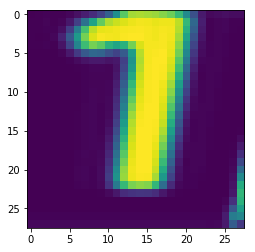

In [49]:
# Check image source
i = 1
im = np.asarray(data.iloc[i, 1:], dtype=np.float32).reshape(28,28)
plt.imshow(im)
plt.show()

# logits = model(im)
# y = tf.argmax(tf.nn.softmax(logits), axis = 1)
# print("\nThe Character is:", le.inverse_transform(y.numpy()))

In [0]:
images = data.iloc[:, 1:]
labels = data.iloc[:, 0]

In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
print(le.classes_)
labels = le.transform(labels)
print(labels)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[0 1 2 ... 2 6 6]


In [0]:
length = len(labels)
images = np.asarray(images, dtype=np.float32)
labels = np.asarray(labels, dtype=np.int64)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [53]:
x_val.shape

(2976, 784)

In [0]:
def random_batch(x_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(x_train), batch_size)
    x_batch = x_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return x_batch, y_batch

In [0]:
# Training Parameters
batch_size = 128
dropout_rate = 0.1

# Network Parameters
height, width = 28, 28
num_classes = 36

In [0]:
class CNN_Model(tfe.Network):
  def __init__(self):
    super(CNN_Model, self).__init__()
    self.conv1 = self.track_layer(tf.layers.Conv2D(32, 5, activation = tf.nn.relu, padding = "SAME"))
    self.pool1 = self.track_layer(tf.layers.MaxPooling2D(2, 2))
    self.conv2 = self.track_layer(tf.layers.Conv2D(64, 5, activation = tf.nn.relu, padding = "SAME"))
    self.pool2 = self.track_layer(tf.layers.MaxPooling2D(2, 2))
    self.flatten = self.track_layer(tf.layers.Flatten())
    self.fc1 = self.track_layer(tf.layers.Dense(256, activation = tf.nn.relu))
    self.dropout = self.track_layer(tf.layers.Dropout(0.75))
    self.fc2 = self.track_layer(tf.layers.Dense(num_classes, activation = None))
    
  def call(self, input):
    input = tf.reshape(input, [-1, 28, 28, 1])
    result = self.conv1(input)
    result = self.pool1(result)
    result = self.conv2(result)
    result = self.flatten(result)
    result = self.fc1(result)
    result = self.dropout(result)
    result = self.fc2(result)
    return result

In [0]:
def get_accuracy(logits, y_true, test=False):
  global acc_list
  y_pred = tf.argmax(tf.nn.softmax(logits), axis = 1)
  correct = tf.equal(y_pred, y_true)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
#   print(process.memory_info().rss/(10**9))
  if not test:
    acc_list = np.append(acc_list, [[step, accuracy]], axis=0)
    print("step {}:\taccuracy = {}".format(step, accuracy))
  else:
    print("Test accuracy = {}".format(accuracy))  
  
def loss_function(step, model, x, y_true):
  logits = model(x)
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
  loss = tf.reduce_mean(xentropy)
  
  if step % verbose_interval == 0:
    get_accuracy(logits, y_true)
  
  return loss

In [58]:
# Train model
start = 1
num_steps = 200
verbose_interval = 10
learning_rate = 0.001

acc_list = np.array([[0, 0]])
model = CNN_Model()
optimizer = tf.train.AdamOptimizer(learning_rate)

for step in range(start, num_steps + start):
  batch_x, batch_y = random_batch(x_train, y_train, batch_size)
  batch_x = tf.constant(batch_x)
  batch_y = tf.constant(batch_y)
#   print(batch_y)
  optimizer.minimize(lambda: loss_function(step, model, batch_x, batch_y))

print("Optimization Finished!")
start = start + num_steps


Please inherit from `tf.keras.Model`, and see its documentation for details. `tf.keras.Model` should be a drop-in replacement for `tfe.Network` in most cases, but note that `track_layer` is no longer necessary or supported. Instead, `Layer` instances are tracked on attribute assignment (see the section of `tf.keras.Model`'s documentation on subclassing). Since the output of `track_layer` is often assigned to an attribute anyway, most code can be ported by simply removing the `track_layer` calls.

`tf.keras.Model` works with all TensorFlow `Layer` instances, including those from `tf.layers`, but switching to the `tf.keras.layers` versions along with the migration to `tf.keras.Model` is recommended, since it will preserve variable names. Feel free to import it with an alias to avoid excess typing :).
step 10:	accuracy = 0.6015625
step 20:	accuracy = 0.8671875
step 30:	accuracy = 0.9140625
step 40:	accuracy = 0.9296875
step 50:	accuracy = 0.9375
step 60:	accuracy = 0.953125
step 70:	accu

In [59]:
# Additional run to optimize 
learning_rate = 0.0001
steps = 50
verbose_interval = 10
batch_size = 500
optimizer = tf.train.AdamOptimizer(learning_rate)

for step in range(start, start + steps +1):
  batch_x, batch_y = random_batch(x_train, y_train, batch_size)
  batch_x = tf.constant(batch_x)
  batch_y = tf.constant(batch_y)
  optimizer.minimize(lambda: loss_function(step, model, batch_x, batch_y))

start = start + num_steps

step 210:	accuracy = 0.9860000014305115
step 220:	accuracy = 0.9860000014305115
step 230:	accuracy = 0.9980000257492065
step 240:	accuracy = 0.9980000257492065
step 250:	accuracy = 0.9959999918937683


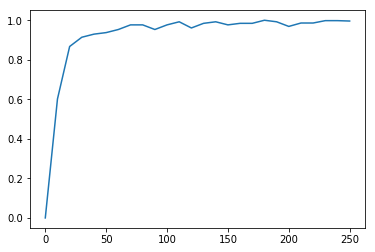

In [60]:
plt.plot(acc_list[:, 0], acc_list[:, 1])
plt.show()

In [0]:
x_test_batch, y_test_batch = random_batch(x_test, y_test, 10000)
logits = model(x_test_batch)
get_accuracy(logits, y_test_batch, test=True)

Test accuracy = 0.9848999977111816


In [61]:
# Remember track_layer in model
# Check variable: 
model.variables
tfe.save_network_checkpoint(model,'./AZ_09.ckpt')

'./AZ_09.ckpt'

In [62]:
# Run at least 1 round before reconstructing. 
input = tf.random_normal((1, 784))
model = CNN_Model()
model(input) # intitiate variable
tfe.restore_network_checkpoint(model,'./AZ_09.ckpt')


Please inherit from `tf.keras.Model`, and see its documentation for details. `tf.keras.Model` should be a drop-in replacement for `tfe.Network` in most cases, but note that `track_layer` is no longer necessary or supported. Instead, `Layer` instances are tracked on attribute assignment (see the section of `tf.keras.Model`'s documentation on subclassing). Since the output of `track_layer` is often assigned to an attribute anyway, most code can be ported by simply removing the `track_layer` calls.

`tf.keras.Model` works with all TensorFlow `Layer` instances, including those from `tf.layers`, but switching to the `tf.keras.layers` versions along with the migration to `tf.keras.Model` is recommended, since it will preserve variable names. Feel free to import it with an alias to avoid excess typing :).
INFO:tensorflow:Restoring parameters from ./AZ_09.ckpt


In [0]:
test_labels = tf.argmax(tf.nn.softmax(logits), axis = 1)
test_labels = le.inverse_transform(test_labels)

In [0]:
a = 1
b = 11

test_imgs = x_test_batch[a:b]

logits = model(test_imgs)

In [76]:
print(test_labels)

['T' 'V' 'J' 'D' 'S' '2' 'U' '7' 'R' 'U']


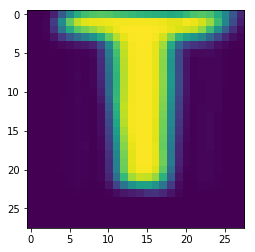

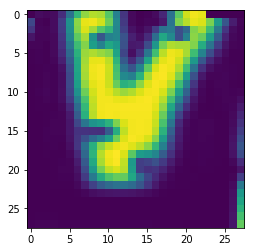

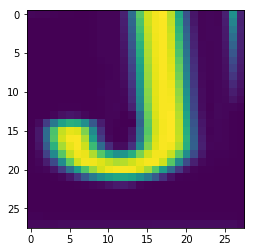

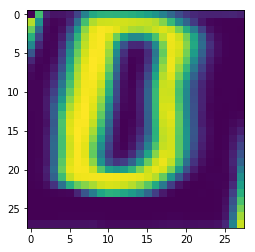

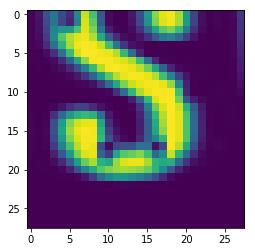

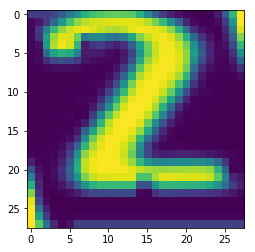

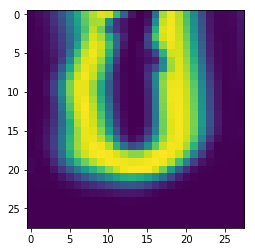

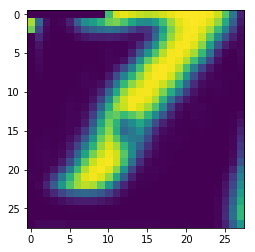

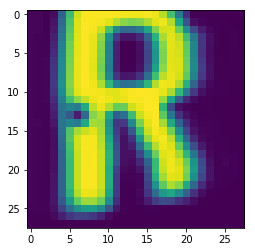

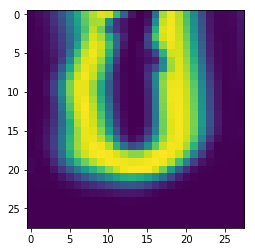

In [77]:


for i in range(a, b):
  plt.imshow(x_test_batch[i].reshape(28, 28))
  plt.show()